## Code from

<< https://www.kaggle.com/yasufuminakama/inchi-resnet-lstm-with-attention-starter >>
* Kaggle : Y.Nakama, yasufuminakama

## Module

In [34]:
import os
from matplotlib import pyplot as plt

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
import numpy as np
import pandas as pd
import torch

import os
import gc
import re
import math
import time
import random
import shutil
import pickle
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import Levenshtein
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, Blur
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

## Device

In [35]:
if torch.cuda.is_available() : 
    GPU_NUM = 7 # 원하는 GPU 번호 입력
    DEVICE = torch.device(f'cuda:{GPU_NUM}')
    torch.cuda.set_device(DEVICE) # change allocation of current GPU
    print ('Current cuda device ', torch.cuda.current_device()) # check
else : 
    DEVICE = torch.device('cpu')
    
print(torch.__version__, DEVICE)

Current cuda device  7
1.7.1 cuda:7


## Constant

In [36]:
PATH = '../../molecular_data/'
TRAIN_DIR = PATH + 'train'

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

class CFG:
    debug = False
    apex = False
    max_len = 275
    print_freq = 1
    num_workers = 0
    model_name = 'efficientnet_b2'
    enc_size = 1408
    samp_size = 100000
    size = 288
    scheduler = 'CosineAnnealingLR' 
    epochs = 1 
    T_max = 4  
    encoder_lr = 1e-4
    decoder_lr = 4e-4
    min_lr = 1e-6
    batch_size = 32
    weight_decay = 1e-6
    gradient_accumulation_steps = 1
    max_grad_norm = 10
    attention_dim = 256
    embed_dim = 512
    decoder_dim = 512
    decoder_layers = 2     # number of LSTM layers
    dropout = 0.5
    seed = 42
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    train = True
    
    prev_model = 'efficientnet_b2_fold0_best.pth'

## Data Load

In [37]:
train = pd.read_pickle('train2.pkl')

train.head()

,image_id,InChI,InChI_1,InChI_text,InChI_length
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,C13H20OS,C 13 H 20 O S /c 1 - 9 ( 2 ) 8 - 15 - 13 - 6 -...,59
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,C21H30O4,C 21 H 30 O 4 /c 1 - 12 ( 22 ) 25 - 14 - 6 - 8...,108
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,C24H23N5O4,C 24 H 23 N 5 O 4 /c 1 - 14 - 13 - 15 ( 7 - 8 ...,112
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,C17H24N2O4S,C 17 H 24 N 2 O 4 S /c 1 - 12 ( 20 ) 18 - 13 (...,108
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,C10H19N3O2S,C 10 H 19 N 3 O 2 S /c 1 - 15 - 10 ( 14 ) 12 -...,72


In [38]:
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

## Tokenizer

In [39]:
# Code From https://www.kaggle.com/yasufuminakama/inchi-resnet-lstm-with-attention-starter

class Tokenizer(object):
    
    def __init__(self):
        self.stoi = {}
        self.itos = {}

    def __len__(self):
        return len(self.stoi)
    
    def fit_on_texts(self, texts):
        vocab = set()
        for text in texts:
            vocab.update(text.split(' '))
        vocab = sorted(vocab)
        vocab.append('<sos>')
        vocab.append('<eos>')
        vocab.append('<pad>')
        for i, s in enumerate(vocab):
            self.stoi[s] = i
        self.itos = {item[1]: item[0] for item in self.stoi.items()}
        
    def text_to_sequence(self, text):
        sequence = []
        sequence.append(self.stoi['<sos>'])
        for s in text.split(' '):
            sequence.append(self.stoi[s])
        sequence.append(self.stoi['<eos>'])
        return sequence
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = self.text_to_sequence(text)
            sequences.append(sequence)
        return sequences

    def sequence_to_text(self, sequence):
        return ''.join(list(map(lambda i: self.itos[i], sequence)))
    
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = self.sequence_to_text(sequence)
            texts.append(text)
        return texts
    
    def predict_caption(self, sequence):
        caption = ''
        for i in sequence:
            if i == self.stoi['<eos>'] or i == self.stoi['<pad>']:
                break
            caption += self.itos[i]
        return caption
    
    def predict_captions(self, sequences):
        captions = []
        for sequence in sequences:
            caption = self.predict_caption(sequence)
            captions.append(caption)
        return captions

tokenizer = torch.load('tokenizer2.pth')
print(f"tokenizer.stoi: {tokenizer.stoi}")

tokenizer.stoi: {'': 0, '(': 1, ')': 2, '*': 3, '+': 4, ',': 5, '-': 6, '.': 7, '/b': 8, '/c': 9, '/h': 10, '/i': 11, '/m': 12, '/p': 13, '/q': 14, '/s': 15, '/t': 16, '0': 17, '00': 18, '000': 19, '0000': 20, '00000': 21, '001': 22, '01': 23, '010': 24, '0100': 25, '011': 26, '1': 27, '10': 28, '10.': 29, '10.2': 30, '10.3': 31, '10.4': 32, '10.5': 33, '10.6': 34, '100': 35, '101': 36, '102': 37, '103': 38, '104': 39, '105': 40, '106': 41, '107': 42, '108': 43, '109': 44, '11': 45, '11.': 46, '11.2': 47, '11.3': 48, '11.4': 49, '11.5': 50, '110': 51, '111': 52, '1111': 53, '11111': 54, '112': 55, '113': 56, '114': 57, '115': 58, '116': 59, '117': 60, '118': 61, '119': 62, '12': 63, '12.': 64, '12.12': 65, '12.2': 66, '12.3': 67, '12.4': 68, '12.5': 69, '12.6': 70, '12.8': 71, '120': 72, '121': 73, '122': 74, '123': 75, '124': 76, '125': 77, '126': 78, '127': 79, '128': 80, '129': 81, '13': 82, '13.': 83, '13.2': 84, '13.3': 85, '13.4': 86, '13.5': 87, '130': 88, '131': 89, '132': 90, 

## DF preprocessing

In [40]:
train['InChI_length'].max()

520

In [41]:
def get_path(img_name) : 
    return f"{TRAIN_DIR}/{img_name[0]}/{img_name[1]}/{img_name[2]}/{img_name}.png"

train['path'] = train['image_id'].apply(get_path)

In [42]:
train.head()

,image_id,InChI,InChI_1,InChI_text,InChI_length,path
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,C13H20OS,C 13 H 20 O S /c 1 - 9 ( 2 ) 8 - 15 - 13 - 6 -...,59,../../molecular_data/train/0/0/0/000011a64c74.png
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,C21H30O4,C 21 H 30 O 4 /c 1 - 12 ( 22 ) 25 - 14 - 6 - 8...,108,../../molecular_data/train/0/0/0/000019cc0cd2.png
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,C24H23N5O4,C 24 H 23 N 5 O 4 /c 1 - 14 - 13 - 15 ( 7 - 8 ...,112,../../molecular_data/train/0/0/0/0000252b6d2b.png
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,C17H24N2O4S,C 17 H 24 N 2 O 4 S /c 1 - 12 ( 20 ) 18 - 13 (...,108,../../molecular_data/train/0/0/0/000026b49b7e.png
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,C10H19N3O2S,C 10 H 19 N 3 O 2 S /c 1 - 15 - 10 ( 14 ) 12 -...,72,../../molecular_data/train/0/0/0/000026fc6c36.png


## Dataset

In [43]:
class TrainDataset(Dataset) : 
    def __init__(self, df, tokenizer, transform) :
        super().__init__()
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform
        
    def __len__(self) : 
        return len(self.df)
        
    def __getitem__(self, index) : 
        image_name = self.df.image_id.iloc[index]
        image = cv2.imread(self.df.path.iloc[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        augmented = self.transform(image = image)
        image = augmented['image']
        
        label = self.df.InChI_text.iloc[index]
        label = self.tokenizer.text_to_sequence(label)
        label_length = len(label)
        label_length = torch.LongTensor([label_length])
        return image, torch.LongTensor(label), label_length

In [44]:
class TestDataset(Dataset) : 
    def __init__(self, df, transform = None) : 
        super().__init__()
        self.df = df
        self.transform = transform
        
    def __len__(self) : 
        return len(self.df)
    
    def __getitem__(self, idx) : 
        path = self.df.path.iloc[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        augmented = self.transform(image = image)
        image = augmented['image']
        return image

In [45]:
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [46]:
trainset = TrainDataset(train, tokenizer, get_transforms(data = 'train'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


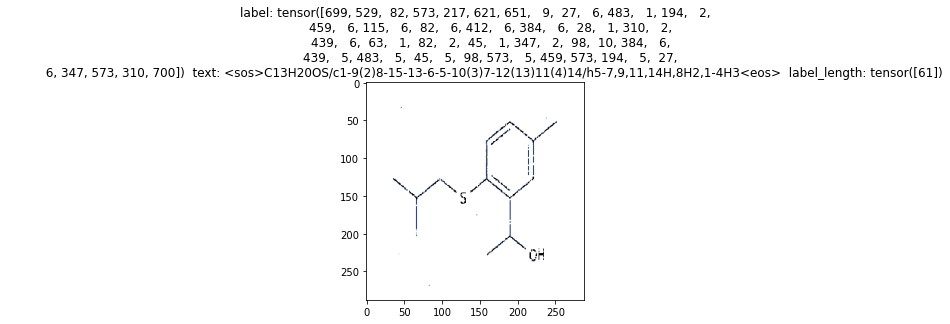

In [47]:
for i in range(1) : 
    image, label, label_length = trainset[i]
    text = tokenizer.sequence_to_text(label.numpy())
    plt.imshow(image.transpose(0, 1).transpose(1, 2))
    plt.title(f'label: {label}  text: {text}  label_length: {label_length}')
    plt.show() 

In [48]:
trainset = []

## Model

In [49]:
if CFG.debug == True :
    model = timm.create_model(CFG.model_name, pretrained = False)
    model

In [50]:
if CFG.debug == True :
    out_test_val = torch.randn(2, 3, 224, 224)
    print(out_test_val.shape)
    out_test = model(out_test_val)
    print(f'shape : {out_test.shape}')
    model.global_pool = nn.Identity()
    model.fc = nn.Identity()
    model

### Encoder

In [51]:
class Encoder(nn.Module) : 
    def __init__(self, model_name = CFG.model_name, pretrained = False) :
        super().__init__()
        self.cnn = timm.create_model(model_name, pretrained = pretrained)
        
    def forward(self, x) : 
        bs = x.size(0)
        features = self.cnn.forward_features(x)
        features = features.permute(0, 2, 3, 1)
        return features

### Attention

In [52]:
class Attention(nn.Module) : 
    def __init__(self, encoder_dim, decoder_dim, attention_dim) : 
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, encoder_out, decoder_hidden) : 
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim = 1)
        return attention_weighted_encoding, alpha

### Decoder

In [53]:
def LSTMCell(input_size, hidden_size, **kwargs):
    m = nn.LSTMCell(input_size, hidden_size, **kwargs)
    for name, param in m.named_parameters():
        if 'weight' in name or 'bias' in name:
            param.data.uniform_(-0.1, 0.1)
    return m

In [54]:
class DecoderWithAttention(nn.Module) : 
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, device, encoder_dim, dropout, num_layers):
        super(DecoderWithAttention, self).__init__()
        self.encoder_dim   = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim     = embed_dim
        self.decoder_dim   = decoder_dim
        self.vocab_size    = vocab_size
        self.dropout       = dropout
        self.num_layers    = num_layers
        self.device        = device
        self.attention     = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network
        self.embedding     = nn.Embedding(vocab_size, embed_dim)                 # embedding layer
        self.dropout       = nn.Dropout(p = self.dropout)
        self.decode_step   = nn.ModuleList([LSTMCell(embed_dim + encoder_dim if layer == 0 else embed_dim, embed_dim) for layer in range(self.num_layers)]) # decoding LSTMCell        
        self.init_h        = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c        = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta        = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid       = nn.Sigmoid()
        self.fc            = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()                                      # initialize some layers with the uniform distribution
        
    def init_weights(self) : 
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        
    def load_pretrained_embeddings(self, embeddings) : 
        self.embedding.weight = nn.Parameter(embeddings)
        
    def fine_tune_embeddings(self, fine_tune = True) : 
        for p in self.embedding.parameters() : 
            p.requires_grad = fine_tune
            
    def init_hidden_state(self, encoder_out) : 
        mean_encoder_out = encoder_out.mean(dim = 1)
        h = [self.init_h(mean_encoder_out) for i in range(self.num_layers)]  # (batch_size, decoder_dim)
        c = [self.init_c(mean_encoder_out) for i in range(self.num_layers)]
        return h, c
    
    def forward(self, encoder_out, encoded_captions, caption_lengths):
        '''
        :param encoder_out: output of encoder network
        :param encoded_captions: transformed sequence from character to integer
        :param caption_lengths: length of transformed sequence
        '''
        batch_size       = encoder_out.size(0)
        encoder_dim      = encoder_out.size(-1)
        vocab_size       = self.vocab_size
        encoder_out      = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels       = encoder_out.size(1)
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim = 0, descending = True)
        encoder_out      = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        
        # embedding transformed sequence for vector
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)
        
        # Initialize LSTM state, initialize cell_vector and hidden_vector
        prev_h, prev_c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        
        # set decode length by caption length - 1 because of omitting start token
        decode_lengths = (caption_lengths - 1).tolist()
        predictions    = torch.zeros(batch_size, max(decode_lengths), vocab_size, device = self.device)
        alphas         = torch.zeros(batch_size, max(decode_lengths), num_pixels, device = self.device)
        
        # predict sequence
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                prev_h[-1][:batch_size_t])
            gate = self.sigmoid(self.f_beta(prev_h[-1][:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding

            input = torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1)
            
            for i, rnn in enumerate(self.decode_step):
                # recurrent cell
                h, c = rnn(input, (prev_h[i][:batch_size_t], prev_c[i][:batch_size_t])) # cell_vector and hidden_vector

                # hidden state becomes the input to the next layer
                input = self.dropout(h)

                # save state for next time step
                prev_h[i] = h
                prev_c[i] = c
                
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :]      = alpha
            
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind
    
    def predict(self, encoder_out, decode_lengths, tokenizer):
        
        # size variables
        batch_size  = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size  = self.vocab_size
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels  = encoder_out.size(1)
        
        # embed start tocken for LSTM input
        start_tockens = torch.ones(batch_size, dtype = torch.long, device = self.device) * tokenizer.stoi['<sos>']
        embeddings    = self.embedding(start_tockens)
        
        # initialize hidden state and cell state of LSTM cell
        h, c        = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        predictions = torch.zeros(batch_size, decode_lengths, vocab_size, device = self.device)
        
        # predict sequence
        end_condition = torch.zeros(batch_size, dtype=torch.long, device = self.device)
        for t in range(decode_lengths):
            awe, alpha = self.attention(encoder_out, h[-1])  # (s, encoder_dim), (s, num_pixels)
            gate       = self.sigmoid(self.f_beta(h[-1]))    # gating scalar, (s, encoder_dim)
            awe        = gate * awe
            
            input = torch.cat([embeddings, awe], dim=1)
 
            for j, rnn in enumerate(self.decode_step):
                at_h, at_c = rnn(input, (h[j], c[j]))  # (s, decoder_dim)
                input = self.dropout(at_h)
                h[j]  = at_h
                c[j]  = at_c
            
            preds = self.fc(self.dropout(h[-1]))  # (batch_size_t, vocab_size)
            predictions[:, t, :] = preds
            end_condition |= (torch.argmax(preds, -1) == tokenizer.stoi["<eos>"])
            if end_condition.sum() == batch_size:
                break
            embeddings = self.embedding(torch.argmax(preds, -1))
        
        return predictions
    
    # beam search
    def forward_step(self, prev_tokens, hidden, encoder_out, function):
        
        h, c = hidden
        #h, c = h.squeeze(0), c.squeeze(0)
        h, c = [hi.squeeze(0) for hi in h], [ci.squeeze(0) for ci in c]
        
        embeddings = self.embedding(prev_tokens)
        if embeddings.dim() == 3:
            embeddings = embeddings.squeeze(1)
            
        awe, alpha = self.attention(encoder_out, h[-1])  # (s, encoder_dim), (s, num_pixels)
        gate       = self.sigmoid(self.f_beta(h[-1]))    # gating scalar, (s, encoder_dim)
        awe        = gate * awe
        
        input = torch.cat([embeddings, awe], dim = 1)
        for j, rnn in enumerate(self.decode_step):
            at_h, at_c = rnn(input, (h[j], c[j]))  # (s, decoder_dim)
            input = self.dropout(at_h)
            h[j]  = at_h
            c[j]  = at_c

        preds = self.fc(self.dropout(h[-1]))  # (batch_size_t, vocab_size)

        #hidden = (h.unsqueeze(0), c.unsqueeze(0))
        hidden = [hi.unsqueeze(0) for hi in h], [ci.unsqueeze(0) for ci in c]
        predicted_softmax = function(preds, dim = 1)
        
        return predicted_softmax, hidden, None

In [55]:
if CFG.debug == True :
    embedding = nn.Embedding(30, 512)
    print(embedding.weight.data)
    print(embedding.weight.data.uniform_(-0.1, 0.1))

In [56]:
if CFG.debug == True :
    fc = nn.Linear(512, 30)
    fc.bias.data

In [57]:
if CFG.debug == True :
    rnd = torch.randn(2, 3, 224, 224)
    print(rnd)
    nn.Parameter(rnd)

In [58]:
if CFG.debug == True :
    rnd = torch.randn(2, 8, 4, 2)
    print(rnd.shape)
    rnd = rnd.mean(dim = 1)
    print(rnd.shape)

In [59]:
if CFG.debug == True :
    rnd = torch.randn(8, 1)
    print(rnd)
    rnd = rnd.squeeze(1)
    print(rnd)
    rnd = rnd.sort(dim = 0, descending = True)
    print(rnd)

In [60]:
if CFG.debug == True :
    dleng = [5, 9]
    for t in range(max(dleng)) : 
        batch_size_t = sum([l > t for l in dleng])
        print(batch_size_t)

In [61]:
if CFG.debug == True :
    start_tokens = torch.ones(16, dtype = torch.long).to(DEVICE) * tokenizer.stoi["<sos>"]
    start_tokens

## Helper functions

In [62]:
def get_score(y_true, y_pred) : 
    scores = []
    
    for true, pred in zip(y_true, y_pred) : 
        score = Levenshtein.distance(true, pred)
        scores.append(score)
        
    avg_score = np.mean(scores)
    return avg_score

In [63]:
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

In [64]:
def seed_torch(seed = 0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed = CFG.seed)

In [65]:
class AverageMeter(object) : 
    def __init__(self) : 
        self.reset()
        
    def reset(self) : 
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n = 1) : 
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [66]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [67]:
def bms_collate(batch):
    imgs, labels, label_lengths = [], [], []
    for data_point in batch:
        imgs.append(data_point[0])
        labels.append(data_point[1])
        label_lengths.append(data_point[2])
    labels = pad_sequence(labels, batch_first=True, padding_value=tokenizer.stoi["<pad>"])
    return torch.stack(imgs), labels, torch.stack(label_lengths).reshape(-1, 1)

## Data Split

In [68]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

for n, (train_index, val_index) in enumerate(Fold.split(folds, folds['InChI_length'])):
    folds.loc[val_index, 'fold'] = int(n)
    
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold']).size())

fold
0    1984645
1    1984645
2    1984644
3    1984644
4    1984644
dtype: int64


## Train

In [29]:
def train_fn(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch,
             encoder_scheduler, decoder_scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    
    encoder.train()
    decoder.train()
    
    start = end = time.time()
    global_step = 0
    
    for step, (images, labels, label_lengths) in enumerate(train_loader):
        data_time.update(time.time() - end)
        
        images = images.to(device)
        labels = labels.to(device)
        label_lengths = label_lengths.to(device)
        batch_size = images.size(0)
        
        features = encoder(images)
        
        predictions, caps_sorted, decode_lengths, alphas, sort_ind = decoder(features, labels, label_lengths)
        targets = caps_sorted[:, 1:]
        predictions = pack_padded_sequence(predictions, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data
        
        loss = criterion(predictions, targets)
        losses.update(loss.item(), batch_size)
        
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
            
        loss.backward()
        
        encoder_grad_norm = torch.nn.utils.clip_grad_norm_(encoder.parameters(), CFG.max_grad_norm)
        decoder_grad_norm = torch.nn.utils.clip_grad_norm_(decoder.parameters(), CFG.max_grad_norm)
        
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            encoder_optimizer.step()
            decoder_optimizer.step()
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            global_step += 1
            
        batch_time.update(time.time() - end)
        end = time.time()
        
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Encoder Grad: {encoder_grad_norm:.4f}  '
                  'Decoder Grad: {decoder_grad_norm:.4f}  '
                  #'Encoder LR: {encoder_lr:.6f}  '
                  #'Decoder LR: {decoder_lr:.6f}  '
                  .format(
                   epoch + 1, step, len(train_loader), batch_time = batch_time,
                   data_time = data_time, loss = losses,
                   remain = timeSince(start, float(step + 1)/len(train_loader)),
                   encoder_grad_norm = encoder_grad_norm,
                   decoder_grad_norm = decoder_grad_norm,
                   #encoder_lr=encoder_scheduler.get_lr()[0],
                   #decoder_lr=decoder_scheduler.get_lr()[0],
                   ))
    return losses.avg

In [30]:
def valid_fn(valid_loader, encoder, decoder, tokenizer, criterion, device) : 
    batch_time = AverageMeter()
    data_time = AverageMeter()
    
    encoder.eval()
    decoder.eval()
    
    text_preds = []
    start = end = time.time()
    
    for step, (images) in enumerate(valid_loader) : 
        data_time.update(time.time() - end)
        images = images.to(device)
        batch_size = images.size(0)
        
        with torch.no_grad() : 
            features = encoder(images)
            predictions = decoder.predict(features, CFG.max_len, tokenizer)
        
        predicted_sequence = torch.argmax(predictions.detach().cpu(), -1).numpy()
        _text_preds = tokenizer.predict_captions(predicted_sequence)
        text_preds.append(_text_preds)
        
        batch_time.update(time.time() - end)
        end = time.time()
        
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1) :
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  .format(
                   step, len(valid_loader), batch_time = batch_time,
                   data_time = data_time,
                   remain = timeSince(start, float(step + 1)/len(valid_loader)),
                   ))
            
    text_preds = np.concatenate(text_preds)
    return text_preds

In [31]:
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds  = folds.loc[trn_idx].reset_index(drop = True)
    valid_folds  = folds.loc[val_idx].reset_index(drop = True)
    valid_labels = valid_folds['InChI'].values

    train_dataset = TrainDataset(train_folds, tokenizer, transform = get_transforms(data = 'train'))
    valid_dataset = TestDataset(valid_folds, transform = get_transforms(data = 'valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size  = CFG.batch_size, 
                              shuffle     = True, 
                              num_workers = CFG.num_workers, 
                              pin_memory  = True,
                              drop_last   = True, 
                              collate_fn  = bms_collate)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size  = CFG.batch_size, 
                              shuffle     = False, 
                              num_workers = CFG.num_workers,
                              pin_memory  = True, 
                              drop_last   = False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, 
                                          mode     = 'min', 
                                          factor   = CFG.factor, 
                                          patience = CFG.patience, 
                                          verbose  = True, 
                                          eps      = CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, 
                                          T_max      = CFG.T_max, 
                                          eta_min    = CFG.min_lr, 
                                          last_epoch = -1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, 
                                                    T_0        = CFG.T_0, 
                                                    T_mult     = 1, 
                                                    eta_min    = CFG.min_lr, 
                                                    last_epoch = -1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================

    #states = torch.load(CFG.prev_model,  map_location = torch.device('cpu'))

    encoder = Encoder(CFG.model_name, 
                      pretrained = True)
    #encoder.load_state_dict(states['encoder'])
    
    encoder.to(DEVICE)
    encoder_optimizer = Adam(encoder.parameters(), 
                             lr           = CFG.encoder_lr, 
                             weight_decay = CFG.weight_decay, 
                             amsgrad      = False)
    #encoder_optimizer.load_state_dict(states['encoder_optimizer'])
    encoder_scheduler = get_scheduler(encoder_optimizer)
    #encoder_scheduler.load_state_dict(states['encoder_scheduler'])
    
    decoder = DecoderWithAttention(attention_dim = CFG.attention_dim, 
                                   embed_dim     = CFG.embed_dim, 
                                   encoder_dim   = CFG.enc_size,
                                   decoder_dim   = CFG.decoder_dim,
                                   num_layers    = CFG.decoder_layers,
                                   vocab_size    = len(tokenizer), 
                                   dropout       = CFG.dropout, 
                                   device        = DEVICE)
    #decoder.load_state_dict(states['decoder'])
    decoder.to(DEVICE)
    decoder_optimizer = Adam(decoder.parameters(), 
                             lr           = CFG.decoder_lr, 
                             weight_decay = CFG.weight_decay, 
                             amsgrad      = False)
    #decoder_optimizer.load_state_dict(states['decoder_optimizer'])

    decoder_scheduler = get_scheduler(decoder_optimizer)
    #decoder_scheduler.load_state_dict(states['decoder_scheduler'])

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss(ignore_index = tokenizer.stoi["<pad>"])

    best_score = np.inf
    best_loss  = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, encoder, decoder, criterion, 
                            encoder_optimizer, decoder_optimizer, epoch, 
                            encoder_scheduler, decoder_scheduler, DEVICE)

        # eval
        text_preds = valid_fn(valid_loader, encoder, decoder, tokenizer, criterion, DEVICE)
        text_preds = [f"InChI=1S/{text}" for text in text_preds]
        LOGGER.info(f"labels: {valid_labels[:5]}")
        LOGGER.info(f"preds: {text_preds[:5]}")
        
        # scoring
        score = get_score(valid_labels, text_preds)
        
        if isinstance(encoder_scheduler, ReduceLROnPlateau):
            encoder_scheduler.step(score)
        elif isinstance(encoder_scheduler, CosineAnnealingLR):
            encoder_scheduler.step()
        elif isinstance(encoder_scheduler, CosineAnnealingWarmRestarts):
            encoder_scheduler.step()
            
        if isinstance(decoder_scheduler, ReduceLROnPlateau):
            decoder_scheduler.step(score)
        elif isinstance(decoder_scheduler, CosineAnnealingLR):
            decoder_scheduler.step()
        elif isinstance(decoder_scheduler, CosineAnnealingWarmRestarts):
            decoder_scheduler.step()

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        
        if score < best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'encoder': encoder.state_dict(), 
                        'encoder_optimizer': encoder_optimizer.state_dict(), 
                        'encoder_scheduler': encoder_scheduler.state_dict(), 
                        'decoder': decoder.state_dict(), 
                        'decoder_optimizer': decoder_optimizer.state_dict(), 
                        'decoder_scheduler': decoder_scheduler.state_dict(), 
                        'text_preds': text_preds,
                       },
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')

In [32]:
def main() : 
    if CFG.train : 
        oof_df = pd.DataFrame()
        
        for fold in range(CFG.n_fold) : 
            if fold in CFG.trn_fold : 
                train_loop(folds, fold)

In [33]:
if __name__ == '__main__' : 
    main()

========== fold: 0 training ==========


Epoch: [1][0/25] Data 0.173 (0.173) Elapsed 0m 1s (remain 0m 29s) Loss: 6.5840(6.5840) Encoder Grad: 0.7226  Decoder Grad: 0.9260  
Epoch: [1][1/25] Data 0.164 (0.169) Elapsed 0m 2s (remain 0m 23s) Loss: 6.4494(6.5167) Encoder Grad: 0.6151  Decoder Grad: 1.2206  
Epoch: [1][2/25] Data 0.108 (0.149) Elapsed 0m 2s (remain 0m 20s) Loss: 6.1511(6.3948) Encoder Grad: 0.8615  Decoder Grad: 1.7373  
Epoch: [1][3/25] Data 0.089 (0.134) Elapsed 0m 3s (remain 0m 18s) Loss: 5.7612(6.2364) Encoder Grad: 1.3392  Decoder Grad: 1.4869  
Epoch: [1][4/25] Data 0.092 (0.125) Elapsed 0m 4s (remain 0m 16s) Loss: 5.4957(6.0883) Encoder Grad: 1.9619  Decoder Grad: 1.7158  
Epoch: [1][5/25] Data 0.102 (0.121) Elapsed 0m 4s (remain 0m 15s) Loss: 5.1708(5.9354) Encoder Grad: 1.6072  Decoder Grad: 1.5596  
Epoch: [1][6/25] Data 0.091 (0.117) Elapsed 0m 5s (remain 0m 14s) Loss: 4.9354(5.7925) Encoder Grad: 2.1670  Decoder Grad: 1.4910  
Epoch: [1][7/25] Data 0.098 (0.115) Elapsed 0m 6s (remain 0m 13s) Loss: 4.76

labels: ['InChI=1S/C9H6N2O3/c12-11(13)8-6-14-10-9(8)7-4-2-1-3-5-7/h1-6H'
 'InChI=1S/C10H11F2IN6OS/c1-3-21-10-15-14-8(7(11)12)19(10)17-9(20)6-5(13)4-18(2)16-6/h4,7H,3H2,1-2H3,(H,17,20)'
 'InChI=1S/C26H25BrN2O5/c1-16-8-10-20(11-9-16)26(31)34-25-21(27)12-19(13-23(25)32-4)14-28-29-24(30)15-33-22-7-5-6-17(2)18(22)3/h5-14H,15H2,1-4H3,(H,29,30)/b28-14+'
 'InChI=1S/C16H18ClN3O4/c1-8-14(9(2)20(4)19-8)18-15(22)10(3)24-16(23)12-6-5-11(17)7-13(12)21/h5-7,10,21H,1-4H3,(H,18,22)/t10-/m0/s1'
 'InChI=1S/C10H9N3O2/c11-7-3-1-2-6(4-7)8-5-12-10(15)13-9(8)14/h1-5H,11H2,(H2,12,13,14,15)']
preds: ['InChI=1S/CHHHHH-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------', 'InChI=1S/CHHHH-------------------------------------------------------------------------------------------------------------------

EVAL: [6/7] Data 0.029 (0.088) Elapsed 0m 2s (remain 0m 0s) 
